# Run CalicoST on prostate cancer dataset

## Obtain the data

We obtained the spatially resolved transcriptomics of a prostate cross section studied by [Erickon et al.](https://www.nature.com/articles/s41586-022-05023-2) from EGA using accession [EGAD00001008644](https://ega-archive.org/datasets/EGAD00001008644). We ran spaceranger to get the BAM files and applied CalicoST to study the CNAs and spatial evolution of cancer across multiple spatial regions.


## Compute allele counts by preprocessing: genotyping and reference-based phasing

**Step 1: Download SNP and phasing panels**

Download the following files to your machine.
* [SNP panel](https://sourceforge.net/projects/cellsnp/files/SNPlist/genome1K.phase3.SNP_AF5e4.chr1toX.hg38.vcf.gz) - 0.5GB in size. You can also choose other SNP panels from [cellsnp-lite webpage](https://cellsnp-lite.readthedocs.io/en/latest/main/data.html#data-list-of-common-snps).
* [Phasing panel](http://pklab.med.harvard.edu/teng/data/1000G_hg38.zip)- 9.0GB in size. Unzip the panel after downloading.

**Step 2: Make a table for BAM files and slice IDs to jointly genotype and phase**

In order to jointly genotype and phase across multiple slices, CalicoST requires a `bamlist.tsv` file that specifies the BAM file paths, slice IDs, and spaceranger output directories. It **must** be tab-deliminated, **without** header, and contain the following columns **in order**, otherwise the pipeline will report an error.

| BAM file location | slide ID | spaceranger out directory location |
| ----------------- | -------- | ---------------------------------- |

Below is the `bamlist.tsv` file we used for the prostate cancer data.
<div style="background-color:black;">

```
/u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H1_2_visium/outs/possorted_genome_bam.bam        H12     /u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H1_2_visium/outs/
/u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H1_4_visium/outs/possorted_genome_bam.bam        H14     /u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H1_4_visium/outs/
/u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H1_5_visium/outs/possorted_genome_bam.bam        H15     /u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H1_5_visium/outs/
/u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H2_1_visium/outs/possorted_genome_bam.bam        H21     /u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H2_1_visium/outs/
/u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H2_5_visium/outs/possorted_genome_bam.bam        H25     /u/congma/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_spaceranger/P1_H2_5_visium/outs/
```

</div>

**Step 3: Make a config.yaml for snakemake preprocessing pipeline**

Besides the BAM files, we also need to specify the reference SNPs and phasing panels and other running configurations. These will be specified in the `config.yaml` file. A [template `config.yaml` file](https://github.com/raphael-group/CalicoST/blob/main/config.yaml) is available in our github. You can modify the template with paths to the references on our machine. Below is the content of `config.yaml` file we used.


<div style="background-color:black;">

```
# path to executables or their parent directories
calicost_dir: /n/fs/ragr-data/users/congma/Codes/CalicoST
eagledir: /n/fs/ragr-data/users/congma/environments/Eagle_v2.4.1

# running parameters
# samtools sort (only used when joingly calling from multiple slices)
samtools_sorting_mem: "4G"
# cellsnp-lite
UMItag: "Auto"
cellTAG: "CB"
nthreads_cellsnplite: 20
region_vcf: /n/fs/ragr-data/users/congma/references/snplist/nocpg.genome1K.phase3.SNP_AF5e4.chr1toX.hg38.vcf.gz
# Eagle phasing
phasing_panel: /n/fs/ragr-data/users/congma/references/phasing_ref/1000G_hg38
chromosomes: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

# input
bamlist: /n/fs/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_snps/joint_H1_245_H2_15/bamlist.tsv

# output
output_snpinfo: /n/fs/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_snps/joint_H1_245_H2_15
```

</div>

**Step 4: Run the proprocessing snakemake pipeline**

With the input of modified `config.yaml` file, we run the snakemake pipeline `calicost.smk` as follows.
```bash
snakemake --cores <number threads> --configfile config.yaml --snakefile calicost.smk all
```

**Key outputs of the snakemake preprocessing pipeline**

In the directory specified in `output_snpinfo` entry of the `config.yaml` file, we will see the following allele count files
* cell_snp_Aallele.npz: A scipy sparse matrix of number spots * number SNPs, each entry indicates the UMI counts of the first haplotype phased by Eagle2.
* cell_snp_Ballele.npz: A scipy sparse matrix of number spots * number SNPs, each entry indicates the UMI counts of the second haplotype phased by Eagle2.
* unique_snp_ids.npy: The ID each the SNPs, corresponding to the columns of scipy sparse matrices.
* barcodes.txt: The spot barcodes (with slide IDs appended as suffix), corresponding to the rows of scipy sparse matrices.

## Estimate tumor proportion per spot

**Step 1: Make the `configuration_purity` file**
To use CalicoST for inferring tumor proportion, first set up a configuration file for CalicoST to specify the input paths, output paths, and running configurations. A [template `configuration_purity`](https://github.com/raphael-group/CalicoST/blob/main/configuration_purity) file is available at the github repo. Modify the input/output directories from the template. We used the following `configuration_purity` file for estimating tumor purity on the prostate cancer data.

<div style="background-color:black;">

```
input_filelist : /n/fs/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_snps/joint_H1_245_H2_15/bamlist.tsv
snp_dir : /n/fs/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_snps/joint_H1_245_H2_15
output_dir : /n/fs/ragr-data/users/congma/Datasets/CalicoST_prostate_example/estimate_tumor_prop

# supporting files and preprocessing arguments
geneticmap_file : /n/fs/ragr-data/users/congma/Codes/CalicoST/GRCh38_resources/genetic_map_GRCh38_merged.tab.gz
hgtable_file : /n/fs/ragr-data/users/congma/Codes/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt
normalidx_file : None
tumorprop_file : None
alignment_files :
supervision_clone_file : None
filtergenelist_file : /n/fs/ragr-data/users/congma/Codes/CalicoST/GRCh38_resources/ig_gene_list.txt
filterregion_file : /n/fs/ragr-data/users/congma/Codes/CalicoST/GRCh38_resources/HLA_regions.bed
secondary_min_umi : 400
bafonly : False

# phase switch probability
nu : 1.0
logphase_shift : -2.0
npart_phasing : 3

# HMRF configurations
n_clones : 5
n_clones_rdr : 2
min_spots_per_clone : 100
min_avgumi_per_clone : 10
maxspots_pooling : 19
tumorprop_threshold : 0.7
max_iter_outer : 20
nodepotential : weighted_sum
initialization_method : rectangle
num_hmrf_initialization_start : 0
num_hmrf_initialization_end : 1
spatial_weight : 1.0
construct_adjacency_method : hexagon
construct_adjacency_w : 1.0

# HMM configurations
n_states : 7
params : smp
t : 1-1e-4
t_phaseing : 0.9999
fix_NB_dispersion : False
shared_NB_dispersion : True
fix_BB_dispersion : False
shared_BB_dispersion : True
max_iter : 30
tol : 0.0001
gmm_random_state : 0
np_threshold : 1.0
np_eventminlen : 10

# integer copy number
nonbalance_bafdist : 1.0
nondiploid_rdrdist : 10.0
```

</div>

For more information of the running configurations, refer to [this page](https://calicost.readthedocs.io/en/latest/parameters.html) in the documentations.

**Step 2: Run the tumor purity estimation module in CalicoST**

We run the following command in terminal

```
# make the output directory
mkdir -p /n/fs/ragr-data/users/congma/Datasets/CalicoST_prostate_example/estimate_tumor_prop/
# run CalicoST to infer tumor purity
OMP_NUM_THREADS=1 python <CalicoST git-cloned directory>/src/calicost/estimate_tumor_proportion.py -c configuration_purity
```

This command takes about 1.5 hours to run and will generate an output file of `loh_estimator_tumor_prop.tsv` in the output directory.

### Load and visualize inferred tumor proportions

We load and visualize the estimated tumor proportions as follows.

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import copy

In [2]:
# Modify the example_directory to be the path of the downloaded and untarred data.
example_directory = "./"

tumor_proportions = pd.read_csv(f'{example_directory}/estimate_tumor_prop/loh_estimator_tumor_prop.tsv', header=0, index_col=0, sep='\t')
tumor_proportions

Tumor
BARCODES                        
AAACAAGTATCTCCCA-1_H12  0.050000
AAACAGGGTCTATATT-1_H12       NaN
AAACATTTCCCGGATT-1_H12  0.050000
AAACCGGGTAGGTACC-1_H12  0.825997
AAACCGTTCGTCCAGG-1_H12  0.940555
...                          ...
TTGTTCAGTGTGCTAC-1_H25  0.050000
TTGTTGTGTGTCAAGA-1_H25  0.188937
TTGTTTCACATCCAGG-1_H25  0.956014
TTGTTTCATTAGTCTA-1_H25  0.838851
TTGTTTCCATACAACT-1_H25  0.364009

[13344 rows x 1 columns]

                    in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                   
ACGCCTGACACGCGCT-1          0          0          0                1466   
TACCGATCCAACACTT-1          0          1          1                1592   
ATTAAAGCGGACGAGC-1          0          0          2                1466   
GATAAGGGACGATTAG-1          0          1          3                1592   
GTGCAAATCACCAATA-1          0          0          4                1466   

                    pxl_col_in_fullres  
barcode                                 
ACGCCTGACACGCGCT-1                1298  
TACCGATCCAACACTT-1                1370  
ATTAAAGCGGACGAGC-1                1443  
GATAAGGGACGATTAG-1                1515  
GTGCAAATCACCAATA-1                1588  


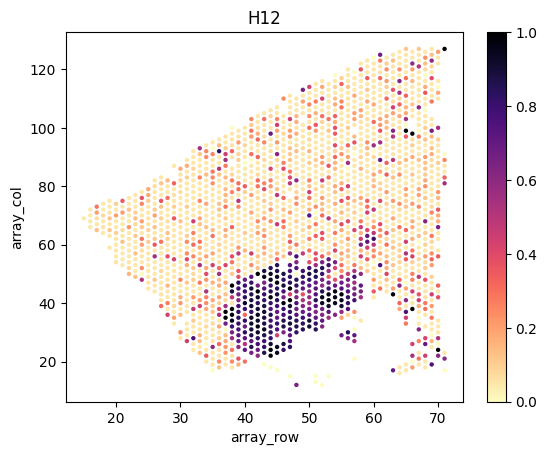

                    in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                   
ACGCCTGACACGCGCT-1          0          0          0                1831   
TACCGATCCAACACTT-1          0          1          1                1983   
ATTAAAGCGGACGAGC-1          0          0          2                1831   
GATAAGGGACGATTAG-1          0          1          3                1983   
GTGCAAATCACCAATA-1          0          0          4                1831   

                    pxl_col_in_fullres  
barcode                                 
ACGCCTGACACGCGCT-1                1544  
TACCGATCCAACACTT-1                1631  
ATTAAAGCGGACGAGC-1                1718  
GATAAGGGACGATTAG-1                1805  
GTGCAAATCACCAATA-1                1892  


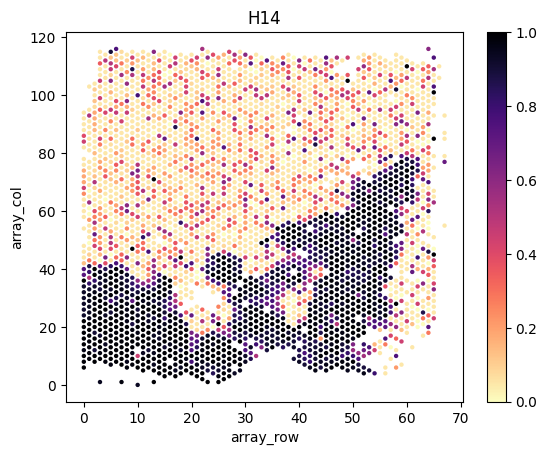

                    in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                   
ACGCCTGACACGCGCT-1          0          0          0                1593   
TACCGATCCAACACTT-1          0          1          1                1720   
ATTAAAGCGGACGAGC-1          0          0          2                1593   
GATAAGGGACGATTAG-1          0          1          3                1719   
GTGCAAATCACCAATA-1          0          0          4                1593   

                    pxl_col_in_fullres  
barcode                                 
ACGCCTGACACGCGCT-1                1172  
TACCGATCCAACACTT-1                1245  
ATTAAAGCGGACGAGC-1                1317  
GATAAGGGACGATTAG-1                1390  
GTGCAAATCACCAATA-1                1462  


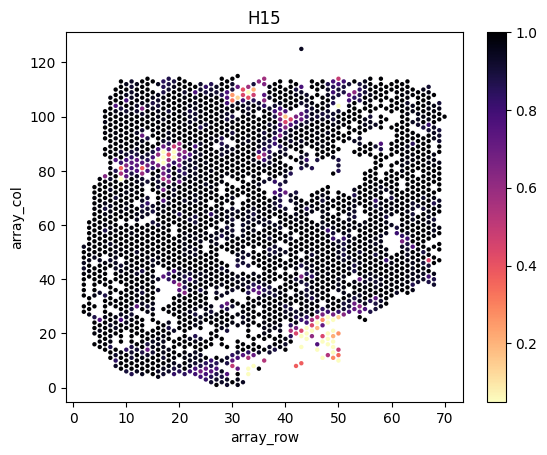

                    in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                   
ACGCCTGACACGCGCT-1          0          0          0                1830   
TACCGATCCAACACTT-1          0          1          1                1982   
ATTAAAGCGGACGAGC-1          0          0          2                1831   
GATAAGGGACGATTAG-1          0          1          3                1982   
GTGCAAATCACCAATA-1          0          0          4                1831   

                    pxl_col_in_fullres  
barcode                                 
ACGCCTGACACGCGCT-1                1523  
TACCGATCCAACACTT-1                1610  
ATTAAAGCGGACGAGC-1                1697  
GATAAGGGACGATTAG-1                1784  
GTGCAAATCACCAATA-1                1871  


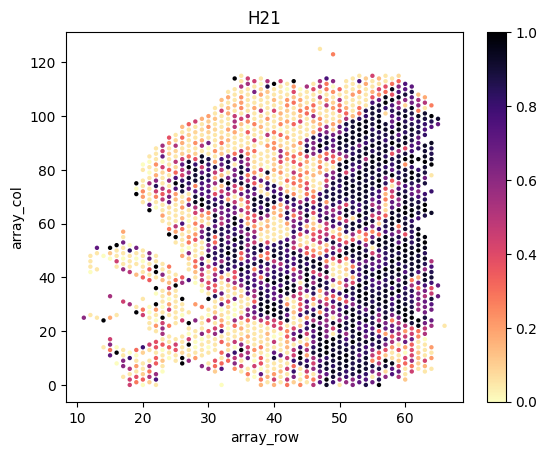

                    in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                   
ACGCCTGACACGCGCT-1          0          0          0                1948   
TACCGATCCAACACTT-1          0          1          1                2100   
ATTAAAGCGGACGAGC-1          0          0          2                1948   
GATAAGGGACGATTAG-1          0          1          3                2100   
GTGCAAATCACCAATA-1          0          0          4                1947   

                    pxl_col_in_fullres  
barcode                                 
ACGCCTGACACGCGCT-1                1441  
TACCGATCCAACACTT-1                1529  
ATTAAAGCGGACGAGC-1                1616  
GATAAGGGACGATTAG-1                1705  
GTGCAAATCACCAATA-1                1791  


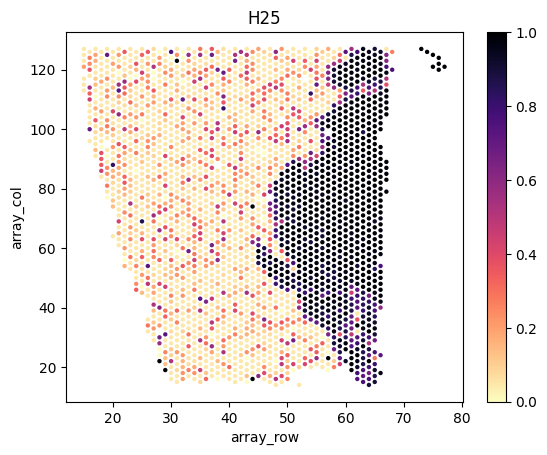

In [3]:
slice_ids = ['H12', 'H14', 'H15', 'H21', 'H25']
directory_name = ['P1_H1_2_visium', 'P1_H1_4_visium', 'P1_H1_5_visium', 'P1_H2_1_visium', 'P1_H2_5_visium']

for i,s in enumerate(slice_ids):
    # load spatial locations
    # note that scanpy is incompatible with the latest tissue_positions.csv file, we directly load the positions as pandas data frame
    df = pd.read_csv(f'{example_directory}/data/{directory_name[i]}/spatial/tissue_positions.csv', header=0, index_col=0, sep=',')
    print(df.head())
    # combine the position data frame with the tumor proportion dataframe
    slice_tumor_proportions = tumor_proportions[tumor_proportions.index.str.endswith(s)]
    df = df.join( slice_tumor_proportions.rename(index=lambda x:x.split("_")[0]) )

    # plot
    fig, axes = plt.subplots(1, 1, facecolor='white')
    sns.scatterplot(x=df.array_row, y=df.array_col, hue=df.Tumor, palette='magma_r', linewidth=0, s=10, legend=False, ax=axes)
    norm = plt.Normalize(np.nanmin(df.Tumor.values), np.nanmax(df.Tumor.values))
    axes.figure.colorbar( plt.cm.ScalarMappable(cmap='magma_r', norm=norm), ax=axes )
    axes.set_title(s)
    plt.show()


## Run CalicoST to infer CNAs and cancer clones based on estimated tumor proportions

**Step 1: Create a configuration file for CalicoST**

The configuration file for CalicoST, `configuration_cna_multi`, specifies the input/output paths and the running parameters. It is very similar to the `configutation_purity` file except that (1) it uses a different output directory, and (2)the "tumorprop_file" entry is now replaced with the output of the inferred tumor purity. Below is the `configuration_cna_multi` file we used.


<div style="background-color:black;">

```
input_filelist : /n/fs/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_snps/joint_H1_245_H2_15/bamlist.tsv
snp_dir : /n/fs/ragr-data/datasets/spatial_cna/Lundeberg_organwide/P1_snps/joint_H1_245_H2_15
output_dir : /n/fs/ragr-data/users/congma/Datasets/CalicoST_prostate_example/calicost

# supporting files and preprocessing arguments
geneticmap_file : /n/fs/ragr-data/users/congma/Codes/CalicoST/GRCh38_resources/genetic_map_GRCh38_merged.tab.gz
hgtable_file : /n/fs/ragr-data/users/congma/Codes/CalicoST/GRCh38_resources/hgTables_hg38_gencode.txt
normalidx_file : None
tumorprop_file : /n/fs/ragr-data/users/congma/Datasets/CalicoST_prostate_example/estimate_tumor_prop/loh_estimator_tumor_prop.tsv
alignment_files :
supervision_clone_file : None
filtergenelist_file : /n/fs/ragr-data/users/congma/Codes/CalicoST/GRCh38_resources/ig_gene_list.txt
filterregion_file : /n/fs/ragr-data/users/congma/Codes/CalicoST/GRCh38_resources/HLA_regions.bed
secondary_min_umi : 400
bafonly : False

# phase switch probability
nu : 1.0
logphase_shift : -2.0
npart_phasing : 3

# HMRF configurations
n_clones : 5
n_clones_rdr : 2
min_spots_per_clone : 100
min_avgumi_per_clone : 10
maxspots_pooling : 19
tumorprop_threshold : 0.7
max_iter_outer : 20
nodepotential : weighted_sum
initialization_method : rectangle
num_hmrf_initialization_start : 0
num_hmrf_initialization_end : 1
spatial_weight : 1.0
construct_adjacency_method : hexagon
construct_adjacency_w : 1.0

# HMM configurations
n_states : 7
params : smp
t : 1-1e-4
t_phaseing : 0.9999
fix_NB_dispersion : False
shared_NB_dispersion : True
fix_BB_dispersion : False
shared_BB_dispersion : True
max_iter : 30
tol : 0.0001
gmm_random_state : 0
np_threshold : 1.0
np_eventminlen : 10

# integer copy number
nonbalance_bafdist : 1.0
nondiploid_rdrdist : 10.0
```

</div>


**Step 2: Run the CalicoST to infer CNAs and clones**

We ran the following command.
```
# create output directory
mkdir -p /n/fs/ragr-data/users/congma/Datasets/CalicoST_prostate_example/calicost
# run CalicoST
OMP_NUM_THREADS=1 python <CalicoST directory>/src/calicost/calicost_main.py -c configuration_cna_multi
```

This command takes about 8h to finish.

### Load CalicoST-generated result tables

`<output_dir>/clone5_rectangle0_w1.0/clone_labels.tsv` stores the inferred cancer clones for each spot. Note that spots with a low tumor purity will also be assigned to a cancer clone, despite that the inferred cancer clone label is not very meaningful for those nearly normal spots.

In [4]:
df = pd.read_csv(f"{example_directory}/calicost/clone5_rectangle0_w1.0/clone_labels.tsv", header=0, index_col=0, sep='\t')
df

clone_label  tumor_proportion
BARCODES                                             
AAACAAGTATCTCCCA-1_H12            3          0.050000
AAACAGGGTCTATATT-1_H12            3               NaN
AAACATTTCCCGGATT-1_H12            3          0.050000
AAACCGGGTAGGTACC-1_H12            3          0.825997
AAACCGTTCGTCCAGG-1_H12            3          0.940555
...                             ...               ...
TTGTTCAGTGTGCTAC-1_H25            2          0.050000
TTGTTGTGTGTCAAGA-1_H25            2          0.188937
TTGTTTCACATCCAGG-1_H25            1          0.956014
TTGTTTCATTAGTCTA-1_H25            1          0.838851
TTGTTTCCATACAACT-1_H25            2          0.364009

[13344 rows x 2 columns]

`<output_dir>/clone5_rectangle0_w1.0/cnv_seglevel.tsv` stores the allele-specific copy numbers of each genome bin within each clone. Each row is a genome bin, the columns containing the chromosome, start, and end position of the genome bin, and the inferred the A and B allele copy number within each cancer clone.

In [5]:
df = pd.read_csv(f"{example_directory}/calicost/clone5_rectangle0_w1.0/cnv_seglevel.tsv", header=0, index_col=None, sep='\t')
df

CHR     START       END  clone1 A  clone1 B  clone2 A  clone2 B  \
0       1     89295   1419136         1         1         1         1   
1       1   1434861   1440568         1         1         1         1   
2       1   1449689   1496123         1         1         1         1   
3       1   1512162   1721078         1         1         1         1   
4       1   1724838   2308568         1         1         1         1   
...   ...       ...       ...       ...       ...       ...       ...   
2255   22  46360834  48898361         1         1         1         1   
2256   22  49773283  49963978         1         1         1         1   
2257   22  50089879  50180213         1         1         1         1   
2258   22  50185915  50292030         1         1         1         1   
2259   22  50309030  50783625         1         1         1         1   

      clone3 A  clone3 B  clone4 A  clone4 B  clone5 A  clone5 B  
0            1         1         1         1         1         1  
1            1         1         1         1         1         1  
2            1         1         1         1         1         1  
3            1         1         1         1         1         1  
4            1         1         1         1         1         1  
...        ...       ...       ...       ...       ...       ...  
2255         1         1         1         1         1         1  
2256         1         1         1         1         1         1  
2257         1         1         1         1         1         1  
2258         1         1         1         1         1         1  
2259         1         1         1         1         1         1  

[2260 rows x 13 columns]

`<output_dir>/clone5_rectangle0_w1.0/cnv_genelevel.tsv` stores the allele-specific copy number for each gene. The copy number per gene is derived from projecting the allele-specific copy numbers of each genome bin to the spanned genes that have enough expression to be retained after CalicoST gene filtering step.

In [6]:
df = pd.read_csv(f"{example_directory}/calicost/clone5_rectangle0_w1.0/cnv_genelevel.tsv", header=0, index_col=None, sep='\t')
df

gene  clone1 A  clone1 B  clone2 A  clone2 B  clone3 A  clone3 B  \
0      AL627309.1         1         1         1         1         1         1   
1      AL627309.5         1         1         1         1         1         1   
2       LINC01409         1         1         1         1         1         1   
3       LINC01128         1         1         1         1         1         1   
4       LINC00115         1         1         1         1         1         1   
...           ...       ...       ...       ...       ...       ...       ...   
15035     CHKB-DT         1         1         1         1         1         1   
15036    MAPK8IP2         1         1         1         1         1         1   
15037        ARSA         1         1         1         1         1         1   
15038      SHANK3         1         1         1         1         1         1   
15039      RABL2B         1         1         1         1         1         1   

       clone4 A  clone4 B  clone5 A  clone5 B  
0             1         1         1         1  
1             1         1         1         1  
2             1         1         1         1  
3             1         1         1         1  
4             1         1         1         1  
...         ...       ...       ...       ...  
15035         1         1         1         1  
15036         1         1         1         1  
15037         1         1         1         1  
15038         1         1         1         1  
15039         1         1         1         1  

[15040 rows x 11 columns]

### Visualize CalicoST-generated plots

Once CalicoST is finished running, it generates the plots of spatial organization of clones and allele-specific copy numbers. The plots are in PDF format and can be directly viewed. Below, we load the PDF plots in this notebook for easy visualization.

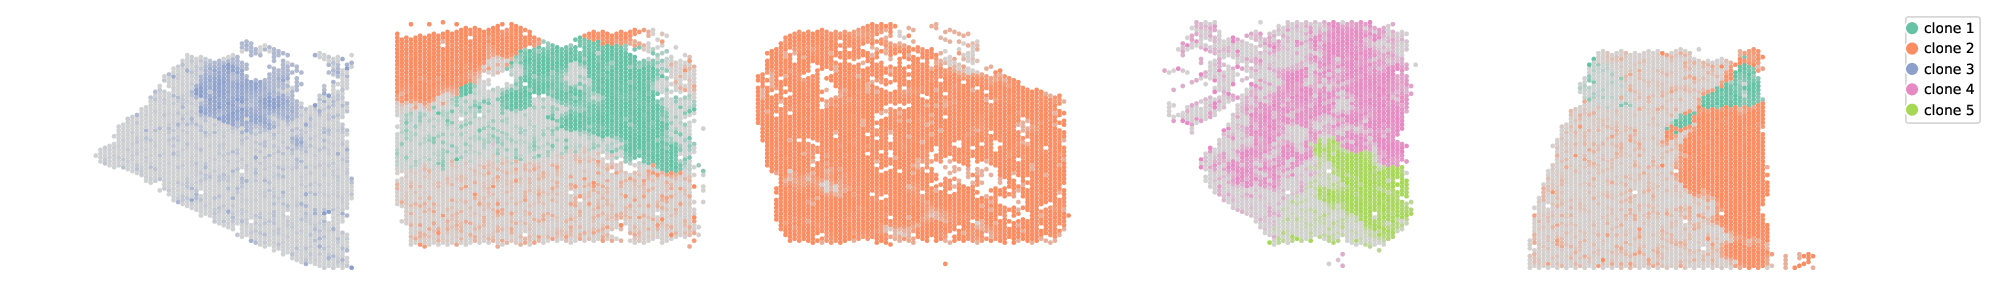

In [7]:
from wand.image import Image as WImage
img = WImage(filename=f"{example_directory}/calicost/clone5_rectangle0_w1.0/plots/clone_spatial.pdf", resolution=100)
img

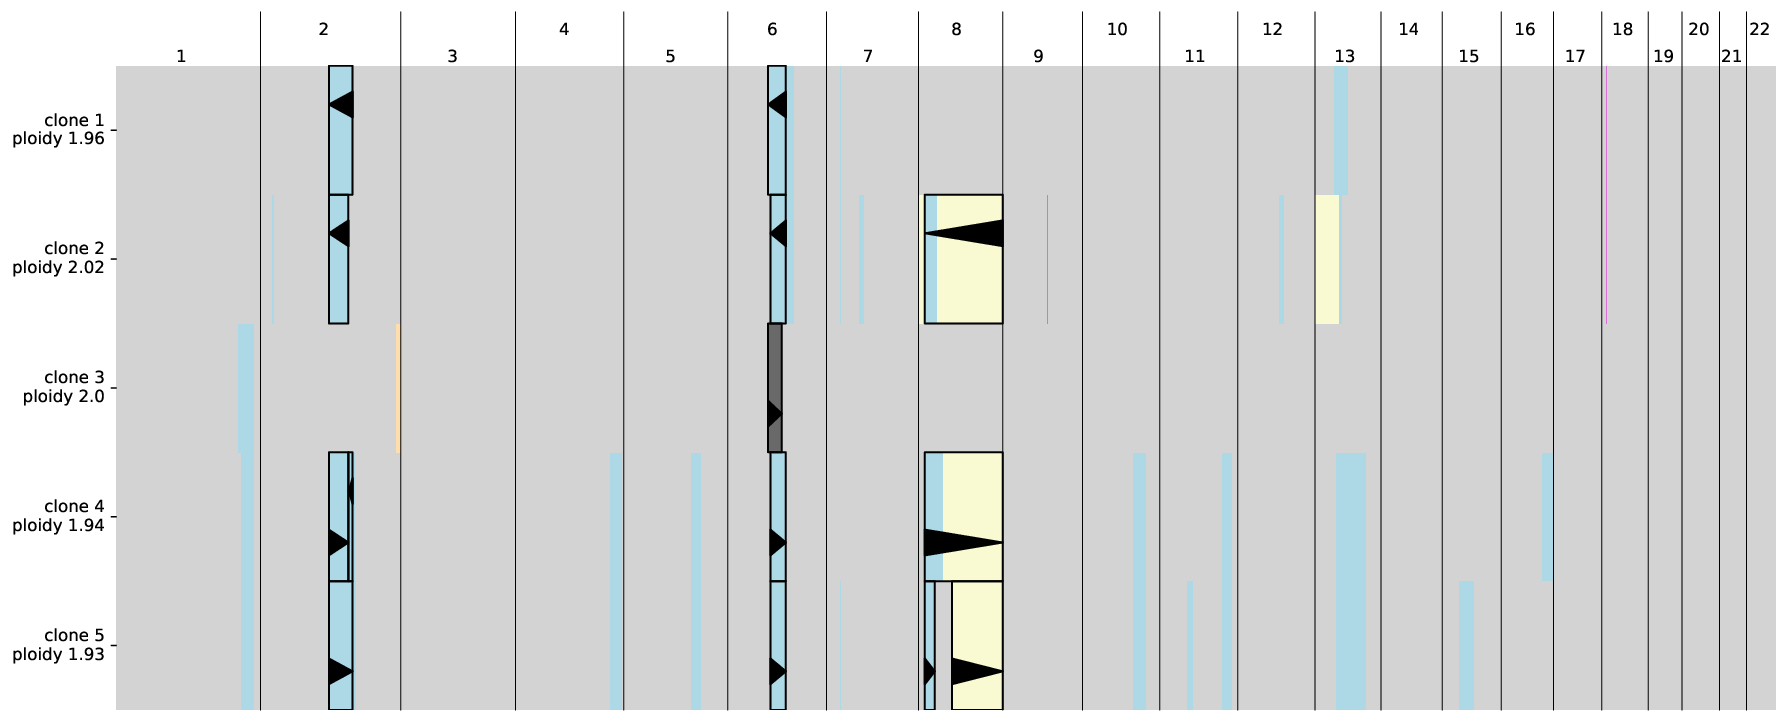

In [8]:
# allele-specific copy numbers of each clone (the color scheme is the same as Fig2c
img = WImage(filename=f"{example_directory}/calicost/clone5_rectangle0_w1.0/plots/acn_genome.pdf", resolution=120)
img

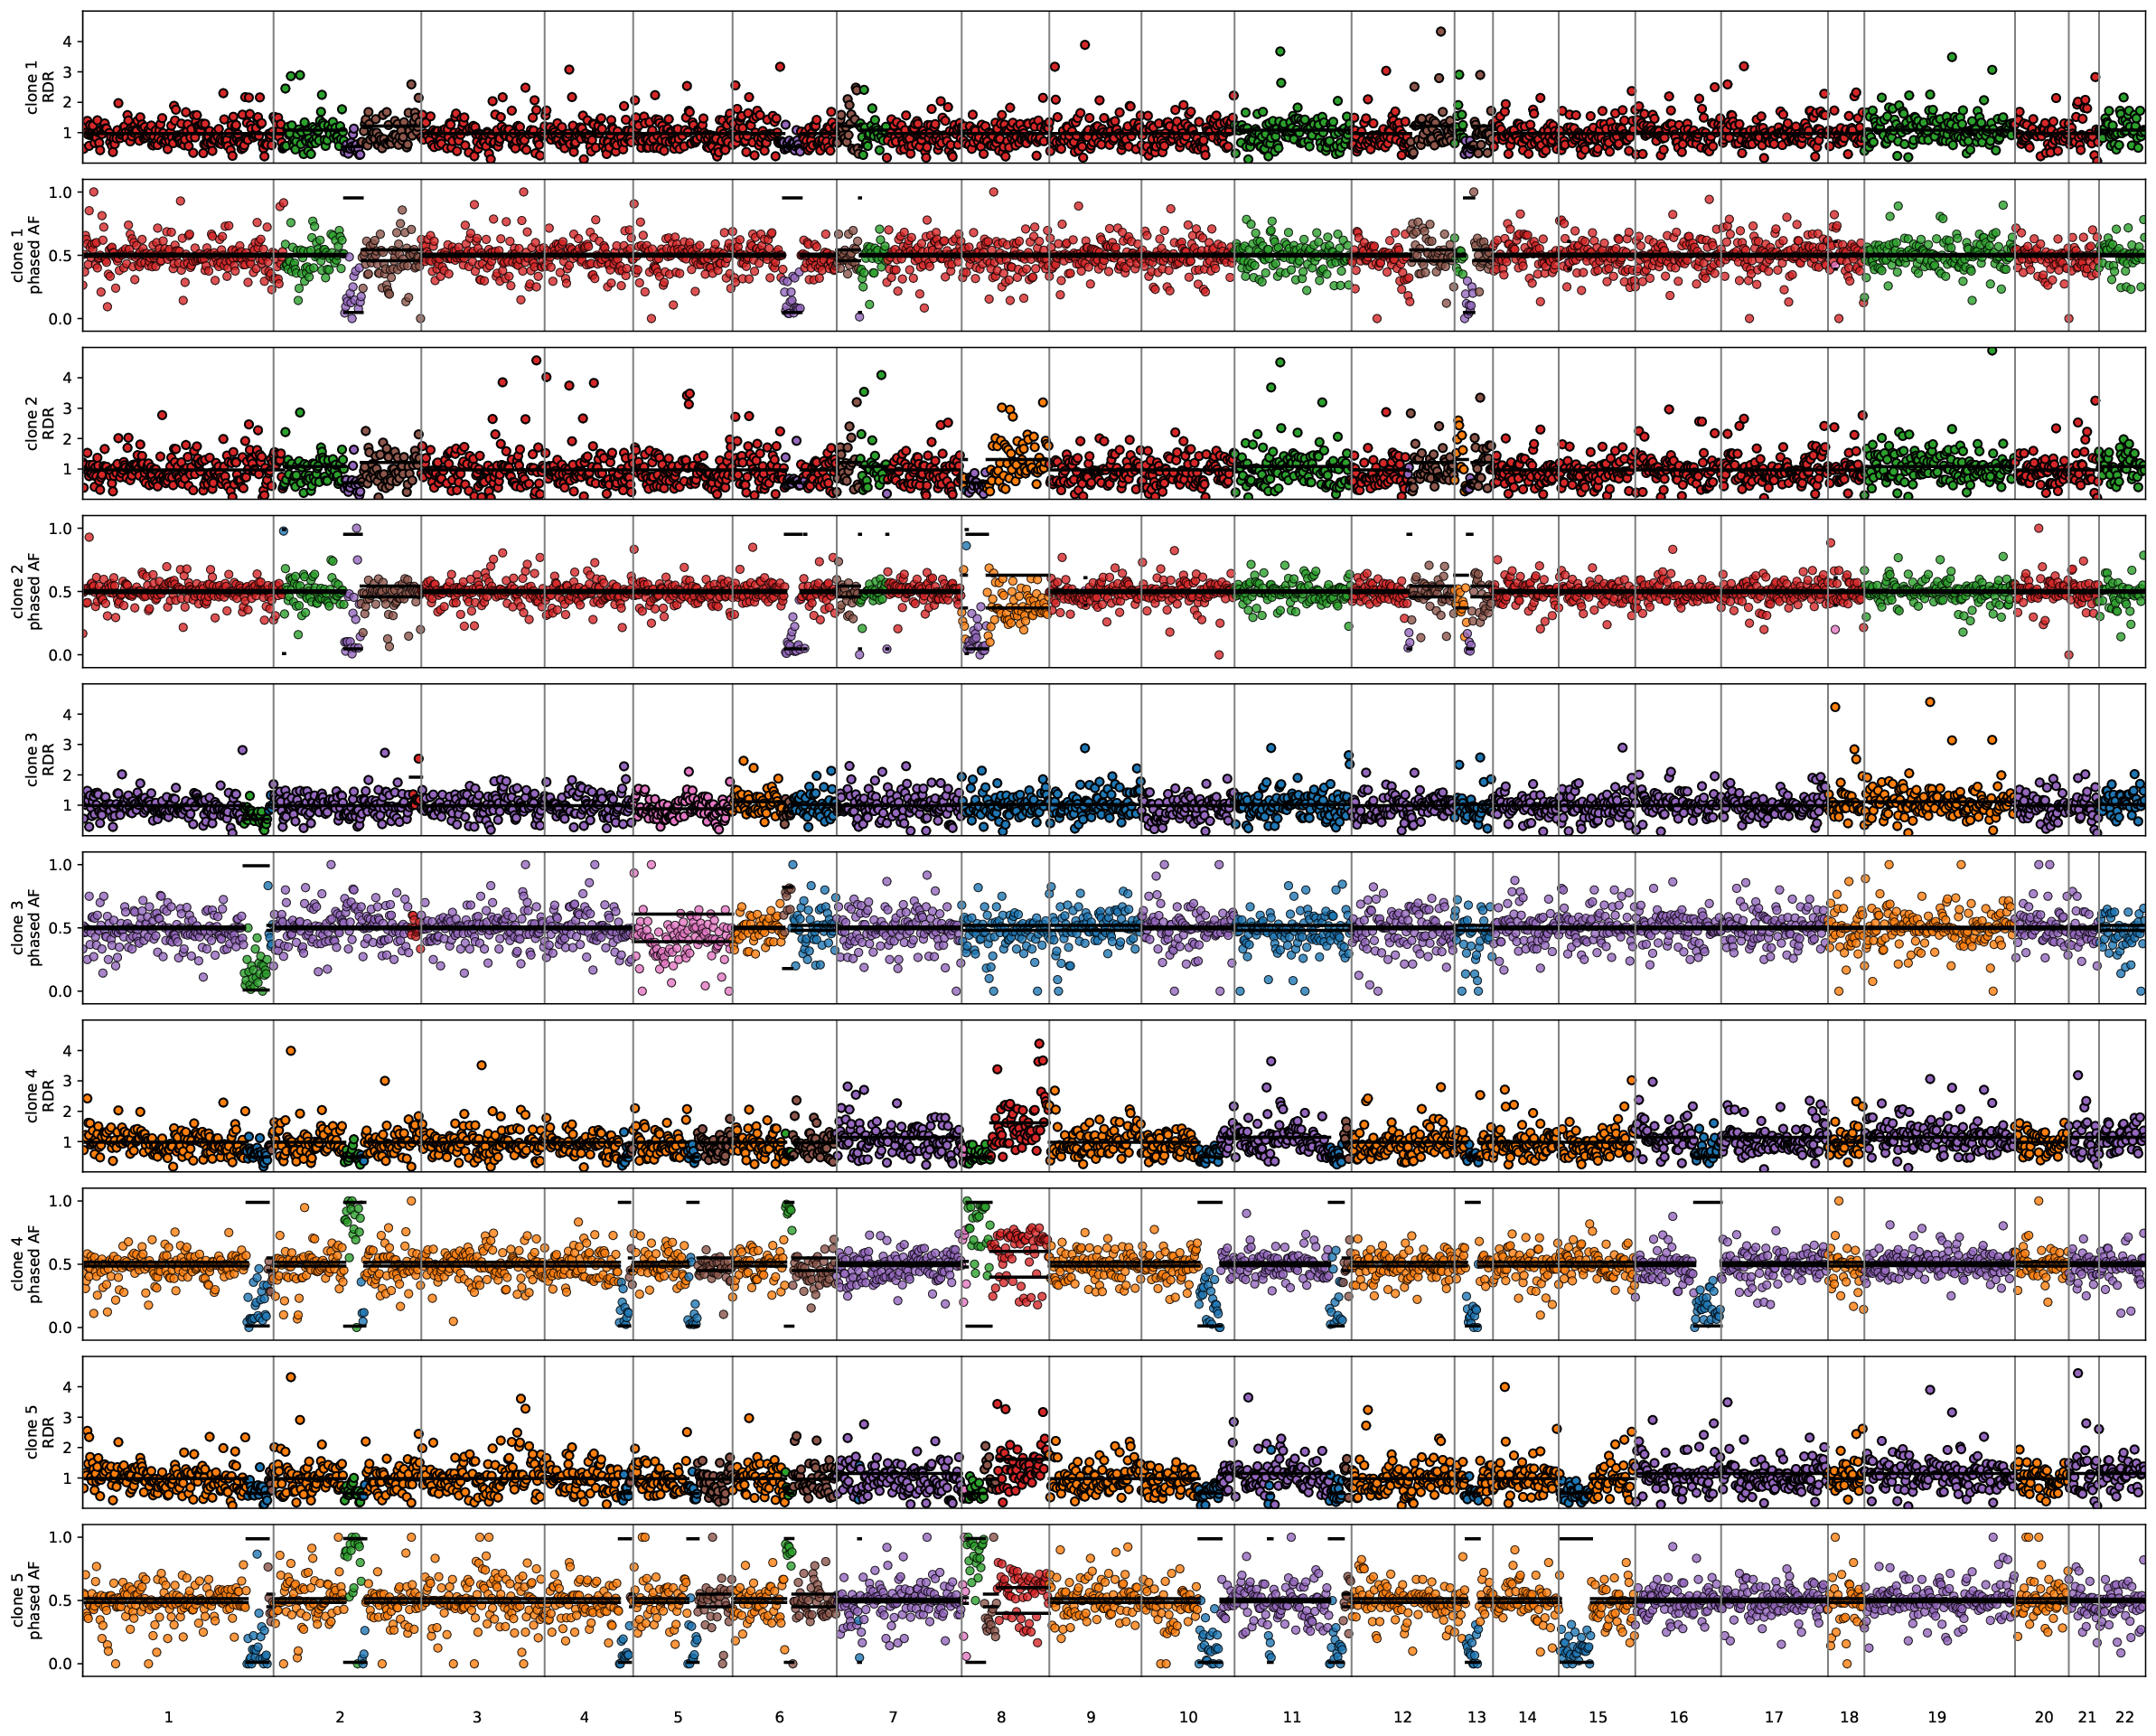

In [9]:
# RDR-BAF plot along the genome for each clone
img = WImage(filename=f"{example_directory}/calicost/clone5_rectangle0_w1.0/plots/rdr_baf_defaultcolor.pdf", resolution=120)
img


## Reconstruct tumor phylogeny and phylogeography

We use an existing phylogeny reconstruction method, [Startle](https://github.com/raphael-group/startle) by [Sashittal et al](https://linkinghub.elsevier.com/retrieve/pii/S2405471223003289), to infer a phylogeny of CalicoST-inferred cancer clones. To reconstruct a phylogeny based CalicoST results of the first random initialization, run the following command in shell:
```
mkdir calicost/phylogeny_clone5_rectangle0_w1.0
python <CalicoST code directory>/src/calicost/phylogeny_startle.py -c calicost/clone5_rectangle0_w1.0 -s <startle executable path> -o calicost/phylogeny_clone5_rectangle0_w1.0/
```

The above run of Startle will produce a plain-text file `calicost/phylogeny_clone5_rectangle0_w1.0/loh_tree.newick` that encodes phylogeny tree with leaf nodes as CalicoST-inferred clones. We load the tree file as follows.

In [10]:
with open(f"{example_directory}/calicost/phylogeny_clone5_rectangle0_w1.0/loh_tree.newick", 'r') as fp:
    print( fp.readlines() )

['((clone1:0,clone2:3):4,(clone3:1,(clone4:3,clone5:3):9):2);']


Now we project the phylogenetic tree in space to get a phylogeography. Before getting the phylogeography, we note that we currently don't have the relative positioning among the five slices yet. We manually place the five slices according to Fig 1b in the original publication by [Erickon et al.](https://www.nature.com/articles/s41586-022-05023-2), and transform the x/y coordinate in the `tissue_positions.csv` file according to the new positioning.

In [11]:
# load coordinates and inferred cancer clones
coords = []
for i,s in enumerate(slice_ids):
    # load spatial locations
    # note that scanpy is incompatible with the latest tissue_positions.csv file, we directly load the positions as pandas data frame
    df = pd.read_csv(f'{example_directory}/data/{directory_name[i]}/spatial/tissue_positions.csv', header=0, index_col=0, sep=',')
    df.index = df.index + "_" + s
    df['slice_id'] = s
    coords.append( df )

coords = pd.concat(coords)

# combine with the cancer clone table
df = pd.read_csv(f"{example_directory}/calicost/clone5_rectangle0_w1.0/clone_labels.tsv", header=0, index_col=0, sep='\t')
df.clone_label = 'clone' + df.clone_label.astype(str)
coords = coords.join(df)

# remove spots that are not assigned to clones by CalicoST (filtered out due to low UMI count or SNP-covering UMI count)
coords = coords[coords.clone_label.notnull()]
coords

in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                       
TCCTTCAGTGGTCGAA-1_H12          1         15         69                3366   
GCGTCGAAATGTCGGT-1_H12          1         17         65                3618   
AACTGATATTAGGCCT-1_H12          1         16         66                3492   
CGAGCTGGGCTTTAGG-1_H12          1         17         67                3618   
GGGTGTTTCAGCTATG-1_H12          1         16         68                3492   
...                           ...        ...        ...                 ...   
ATGGCCCGAAAGGTTA-1_H25          1         76        120               13480   
CGTAATATGGCCCTTG-1_H25          1         77        121               13632   
AGAGTCTTAATGAAAG-1_H25          1         76        122               13480   
ATTGAATTCCCTGTAG-1_H25          1         76        124               13479   
TTGAAGTGCATCTACA-1_H25          1         77        127               13630   

                        pxl_col_in_fullres slice_id clone_label  \
barcode                                                           
TCCTTCAGTGGTCGAA-1_H12                6308      H12      clone3   
GCGTCGAAATGTCGGT-1_H12                6018      H12      clone3   
AACTGATATTAGGCCT-1_H12                6090      H12      clone3   
CGAGCTGGGCTTTAGG-1_H12                6163      H12      clone3   
GGGTGTTTCAGCTATG-1_H12                6236      H12      clone3   
...                                    ...      ...         ...   
ATGGCCCGAAAGGTTA-1_H25               12001      H25      clone2   
CGTAATATGGCCCTTG-1_H25               12089      H25      clone2   
AGAGTCTTAATGAAAG-1_H25               12176      H25      clone2   
ATTGAATTCCCTGTAG-1_H25               12351      H25      clone2   
TTGAAGTGCATCTACA-1_H25               12615      H25      clone2   

                        tumor_proportion  
barcode                                   
TCCTTCAGTGGTCGAA-1_H12          0.050000  
GCGTCGAAATGTCGGT-1_H12          0.132391  
AACTGATATTAGGCCT-1_H12          0.050000  
CGAGCTGGGCTTTAGG-1_H12          0.050000  
GGGTGTTTCAGCTATG-1_H12          0.050000  
...                                  ...  
ATGGCCCGAAAGGTTA-1_H25          1.000000  
CGTAATATGGCCCTTG-1_H25          1.000000  
AGAGTCTTAATGAAAG-1_H25          1.000000  
ATTGAATTCCCTGTAG-1_H25          1.000000  
TTGAAGTGCATCTACA-1_H25               NaN  

[13344 rows x 8 columns]

In [12]:
def flip_axis(coords, axis):
    max_x = np.max(coords[:,axis])
    min_x = np.min(coords[:,axis])
    tmp_coords = copy.copy(coords)
    tmp_coords[:,axis] = min_x + max_x - coords[:,axis]
    return tmp_coords


def rotate_by_angle(coords, angle):
    theta = angle / 180 * np.pi
    R = np.array([ [np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]] )
    mean_coords = np.mean(coords, axis=0)
    return (coords - mean_coords.reshape(1,-1)) @ R + mean_coords.reshape(1,-1)

In [13]:
adjusted_coords = copy.copy(coords[['array_row', 'array_col']].values)
# scale y coordinate so that the hexagon is not squeezed on one direction
adjusted_coords[:,0] = adjusted_coords[:,0] * np.sqrt(3)
# shift x and y coordinate to start from 0 for each slice
for s,sname in enumerate(slice_ids):
    index = np.where(coords.slice_id.values == sname)[0]
    adjusted_coords[index,0] -= np.min(adjusted_coords[index,0])
    adjusted_coords[index,1] -= np.min(adjusted_coords[index,1])
    

# position in number of cubes
cube_length = min( np.max(adjusted_coords[:,0]), np.max(adjusted_coords[:,1]) )
sample_cube_pos = np.array([ [2,0], #H12
                             [4, 0.2], #H14
                             [5,0.5], #H15
                             [0,1], #H21
                             [5,1.5] ]) #H25

swap_x_y = [False, True, True, False, True]
rotation_angle = [15,-5,-5,0,-5] # H12, H14, H15, H21, H25

full_adj_coords = np.zeros(adjusted_coords.shape)
for s,sname in enumerate(slice_ids):
    index = np.where(coords.slice_id.values == sname)[0]
    if swap_x_y[s]:
        tmp_coords = np.vstack([adjusted_coords[index,1],adjusted_coords[index,0]]).T
        if sname != "H25":
            tmp_coords = flip_axis(tmp_coords, axis=0 )
        tmp_coords = flip_axis(tmp_coords, axis=1)
        full_adj_coords[index,:] = tmp_coords + cube_length * sample_cube_pos[s]
    else:
        full_adj_coords[index,:] = adjusted_coords[index,:] + cube_length * sample_cube_pos[s]
        
    full_adj_coords[index,:] = rotate_by_angle(full_adj_coords[index,:], rotation_angle[s])

coords['final_x'] = full_adj_coords[:,0]
coords['final_y'] = full_adj_coords[:,1]
coords

in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                       
TCCTTCAGTGGTCGAA-1_H12          1         15         69                3366   
GCGTCGAAATGTCGGT-1_H12          1         17         65                3618   
AACTGATATTAGGCCT-1_H12          1         16         66                3492   
CGAGCTGGGCTTTAGG-1_H12          1         17         67                3618   
GGGTGTTTCAGCTATG-1_H12          1         16         68                3492   
...                           ...        ...        ...                 ...   
ATGGCCCGAAAGGTTA-1_H25          1         76        120               13480   
CGTAATATGGCCCTTG-1_H25          1         77        121               13632   
AGAGTCTTAATGAAAG-1_H25          1         76        122               13480   
ATTGAATTCCCTGTAG-1_H25          1         76        124               13479   
TTGAAGTGCATCTACA-1_H25          1         77        127               13630   

                        pxl_col_in_fullres slice_id clone_label  \
barcode                                                           
TCCTTCAGTGGTCGAA-1_H12                6308      H12      clone3   
GCGTCGAAATGTCGGT-1_H12                6018      H12      clone3   
AACTGATATTAGGCCT-1_H12                6090      H12      clone3   
CGAGCTGGGCTTTAGG-1_H12                6163      H12      clone3   
GGGTGTTTCAGCTATG-1_H12                6236      H12      clone3   
...                                    ...      ...         ...   
ATGGCCCGAAAGGTTA-1_H25               12001      H25      clone2   
CGTAATATGGCCCTTG-1_H25               12089      H25      clone2   
AGAGTCTTAATGAAAG-1_H25               12176      H25      clone2   
ATTGAATTCCCTGTAG-1_H25               12351      H25      clone2   
TTGAAGTGCATCTACA-1_H25               12615      H25      clone2   

                        tumor_proportion     final_x     final_y  
barcode                                                           
TCCTTCAGTGGTCGAA-1_H12          0.050000  238.417652   74.069483  
GCGTCGAAATGTCGGT-1_H12          0.132391  241.246079   69.170504  
AACTGATATTAGGCCT-1_H12          0.050000  239.573047   70.654068  
CGAGCTGGGCTTTAGG-1_H12          0.050000  241.763717   71.102355  
GGGTGTTTCAGCTATG-1_H12          0.050000  240.090685   72.585919  
...                                  ...         ...         ...  
ATGGCCCGAAAGGTTA-1_H25          1.000000  700.743520  183.090182  
CGTAATATGGCCCTTG-1_H25          1.000000  701.914026  181.184948  
AGAGTCTTAATGAAAG-1_H25          1.000000  702.735909  183.264493  
ATTGAATTCCCTGTAG-1_H25          1.000000  704.728299  183.438805  
TTGAAGTGCATCTACA-1_H25               NaN  707.891194  181.707882  

[13344 rows x 10 columns]

/n/fs/ragr-data/users/congma/temp/CalicoST/src/calicost/utils_plotting.py:1404: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quantile_colors = this_full_cmap(np.array([0, np.min(copy_single_tumor_prop[idx]), np.max(copy_single_tumor_prop[idx]), 1]))
/n/fs/ragr-data/users/congma/temp/CalicoST/src/calicost/utils_plotting.py:1407: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seaborn.scatterplot(x=shifted_coords[idx,0], y=-shifted_coords[idx,1], s=10, hue=copy_single_tumor_prop[idx], palette=this_cmap, linewidth=0, legend=None, ax=axes)
/n/fs/ragr-data/users/congma/temp/CalicoST/src/calicost/utils_plotting.py:1404: Fut

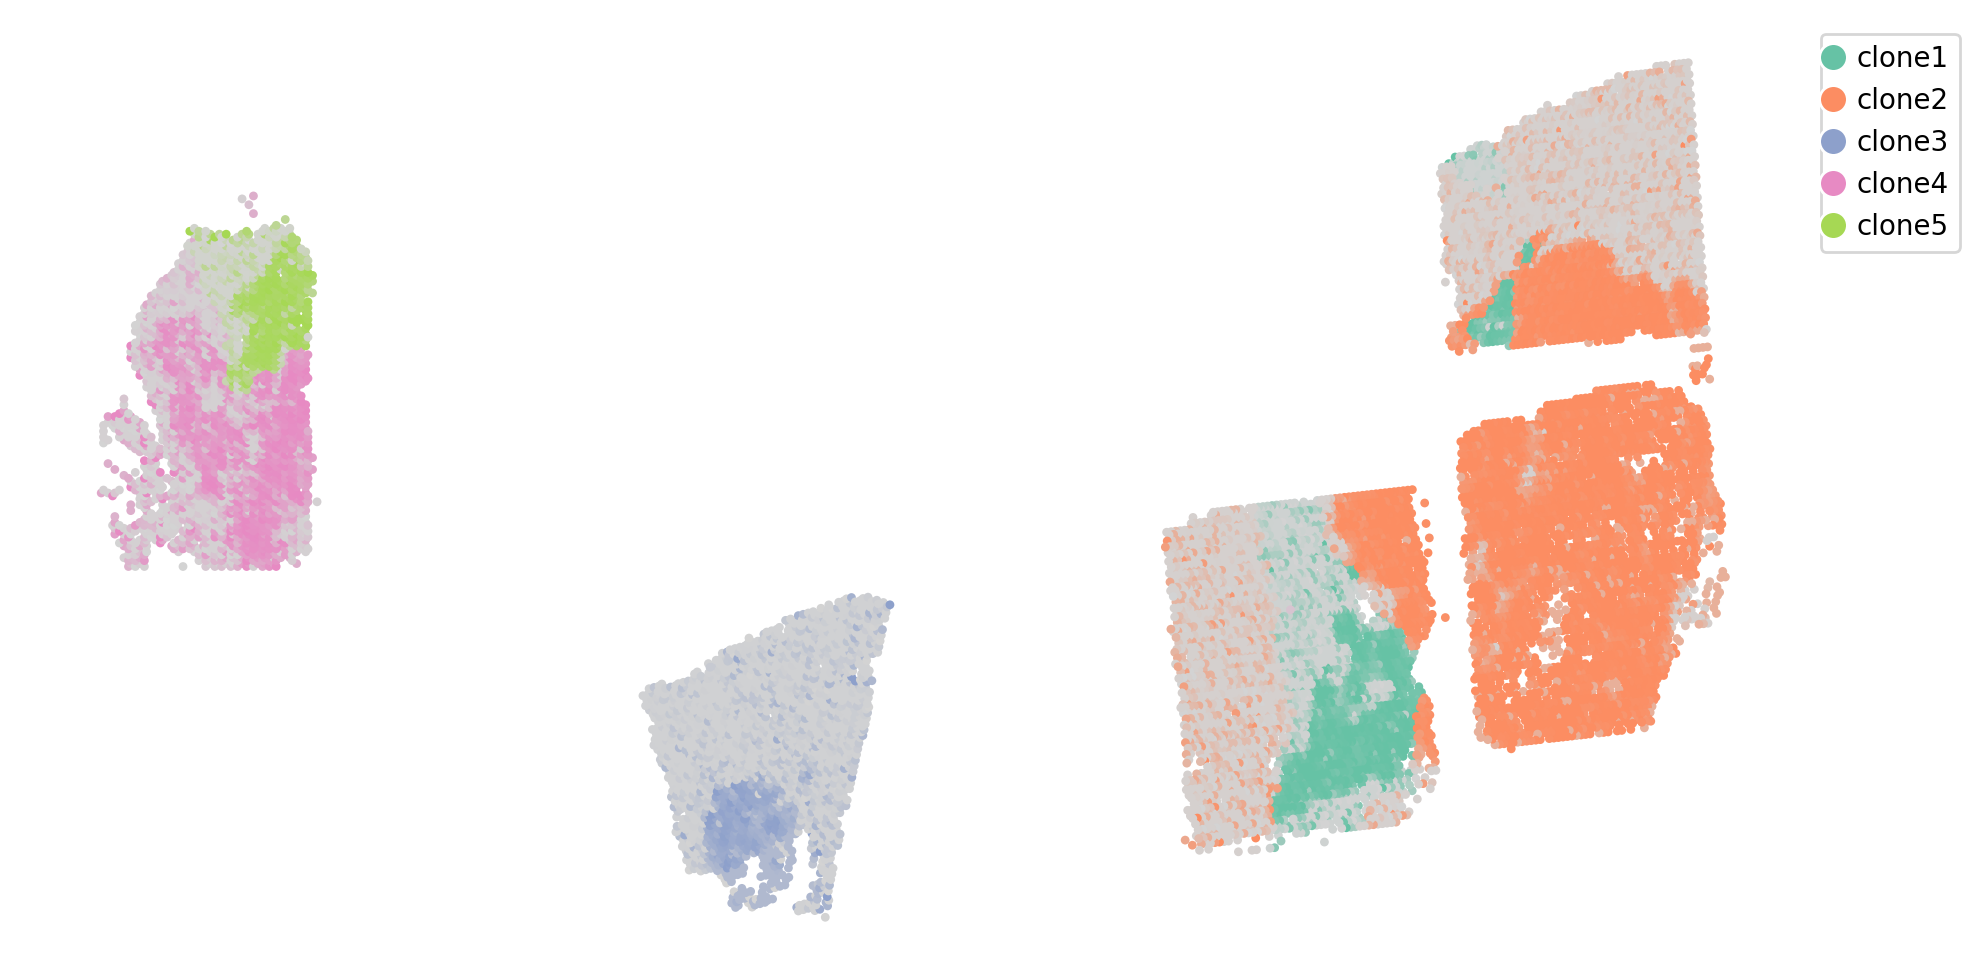

In [14]:
import calicost.utils_plotting

fig = calicost.utils_plotting.plot_individual_spots_in_space(full_adj_coords, coords.clone_label, coords.tumor_proportion, base_width=10, base_height=5)
plt.gca().invert_yaxis()
fig.show()

Now we project the phylogeny to the space of coords[['final_x', 'final_y']] and infer ancestor locations using a Gaussian diffusion model.

In [15]:
import calicost.phylogeography

newick_file = f"{example_directory}/calicost/phylogeny_clone5_rectangle0_w1.0/loh_tree.newick"
t = calicost.phylogeography.project_phylogeneny_space(newick_file, coords[['final_x', 'final_y']].values, coords.clone_label.values, 
                              single_tumor_prop=coords.tumor_proportion.values, sample_list=slice_ids, sample_ids=coords.slice_id.values)

print( t )

root node is ancestor1_2_3_4_5
a list of leaf nodes: ['clone1', 'clone2', 'clone3', 'clone4', 'clone5']
a list of internal nodes: ['ancestor1_2_3_4_5', 'ancestor1_2', 'ancestor3_4_5', 'ancestor4_5']

      /-clone1
   /-|
  |   \-clone2
--|
  |   /-clone3
   \-|
     |   /-clone4
      \-|
         \-clone5


/n/fs/ragr-data/users/congma/temp/CalicoST/src/calicost/utils_plotting.py:1404: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  quantile_colors = this_full_cmap(np.array([0, np.min(copy_single_tumor_prop[idx]), np.max(copy_single_tumor_prop[idx]), 1]))
/n/fs/ragr-data/users/congma/temp/CalicoST/src/calicost/utils_plotting.py:1407: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  seaborn.scatterplot(x=shifted_coords[idx,0], y=-shifted_coords[idx,1], s=10, hue=copy_single_tumor_prop[idx], palette=this_cmap, linewidth=0, legend=None, ax=axes)
/n/fs/ragr-data/users/congma/temp/CalicoST/src/calicost/utils_plotting.py:1404: Fut

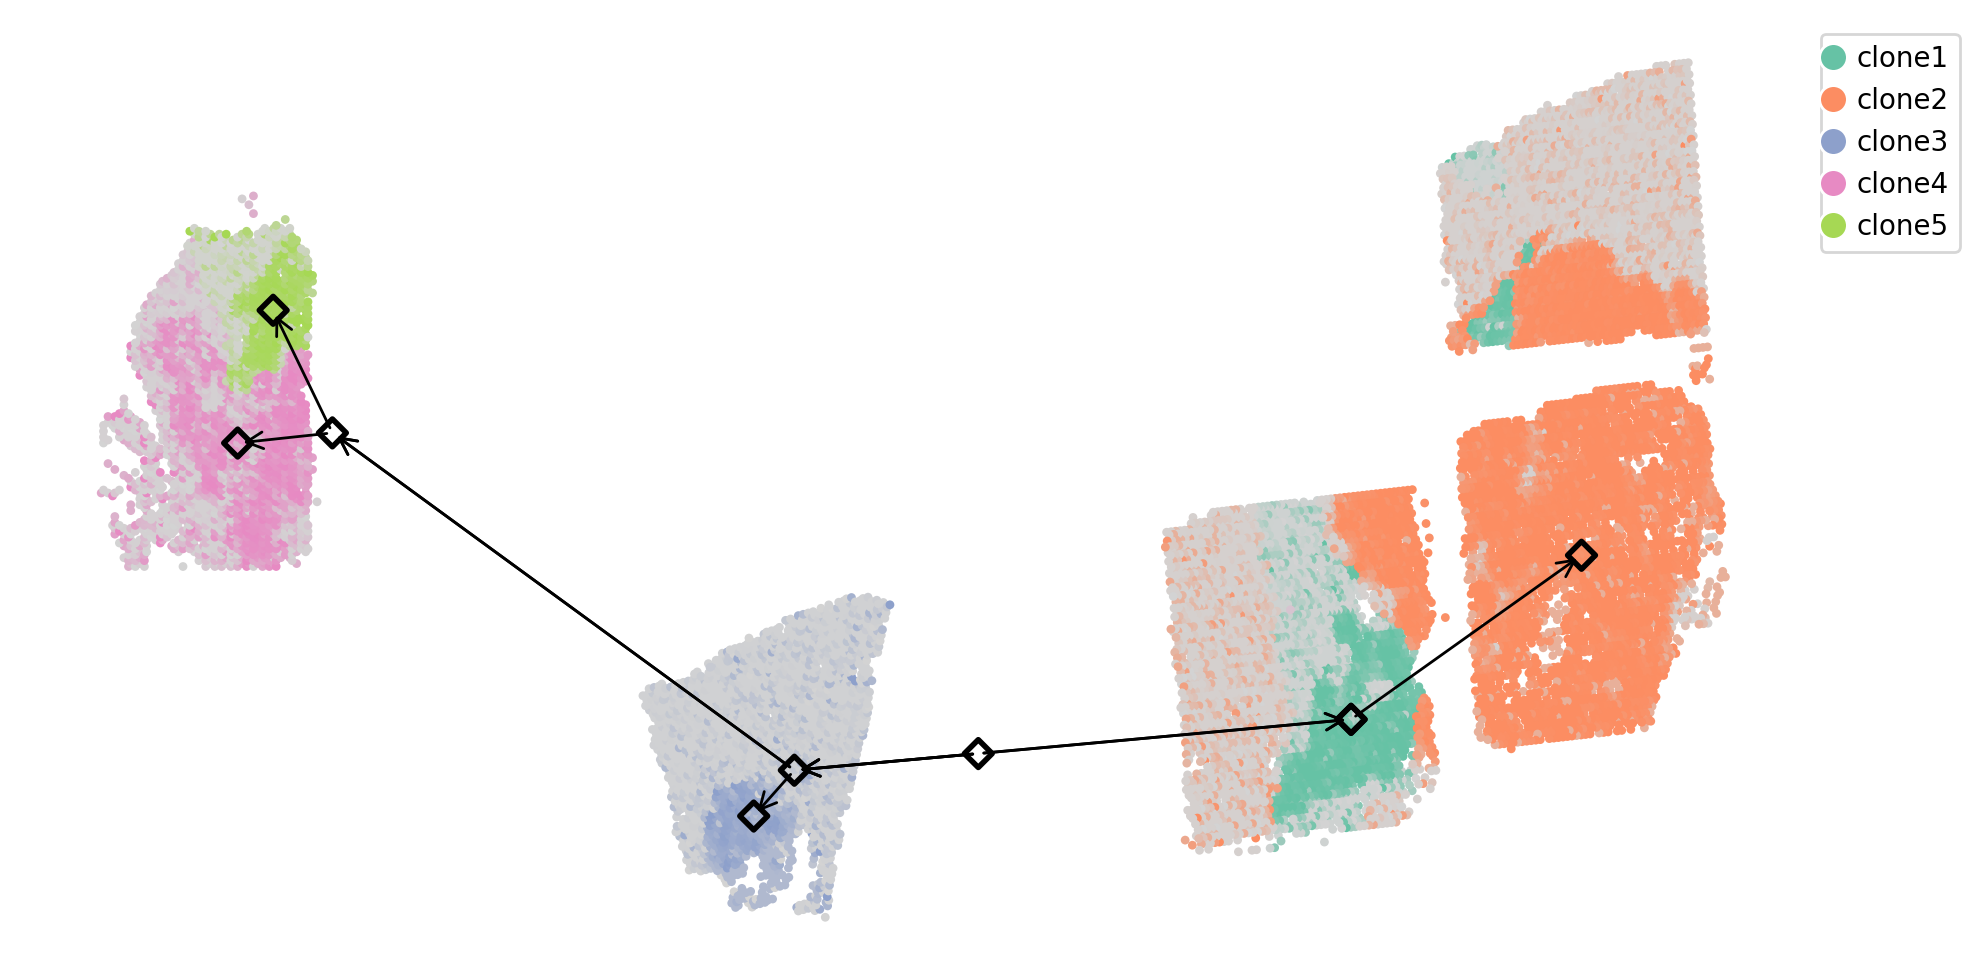

In [16]:
# plot clones in space with the phylogeography

fig = calicost.utils_plotting.plot_individual_spots_in_space(full_adj_coords, coords.clone_label, coords.tumor_proportion, base_width=10, base_height=5)
axes = plt.gca()

# clone centers + ancestors
for node in t.traverse():
    axes.scatter( node.x, -node.y, marker="D", linewidth=2, edgecolor='black', facecolor="None", s=50)

# edges
for node in t.iter_leaves():
    while not node.is_root():
        p = node.up
        if np.abs(node.x - p.x) + np.abs(node.y - p.y) > 1:
            axes.annotate("", xy=(node.x, -node.y), xytext=(p.x, -p.y), arrowprops=dict(mutation_scale=15, lw=1, arrowstyle="->", color="black"))
        node = p
        
axes.invert_yaxis()
fig.show()